In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np
try:
    from docplex.mp.model import Model
except:
    raise Exception('Installez docplex !pip install docplex')

Choix des paramètres

In [12]:
capacité = 60 # capacité de la camionnette du marchand de poisson
nclients = 12 # nombre de clients 
nmagasins = 4 # nombre d'emplacements possibles pour les dépôts
lbdemande = 5 # borne inférieure pour la quantité demandée par les clients
ubdemande = 25 # borne supérieure pour la quantité demandée par les clients

Génération aléatoire des coordonnées des clients et des emplacements potentiels des dépôts

In [13]:
# fixer le seed du random pour toujours avoir les mêmes données 
random.seed(42)
# génération des coordonnées aléatoires des clients  
clients = [(random.randint(0,30), random.randint(0,30)) for _ in range(nclients)]
# génération des coordonnées aléatoires des magasins 
magasins = [(random.randint(0,30), random.randint(0,30)) for _ in range(nmagasins)] 

Affichage des emplacements des dépôts et des clients

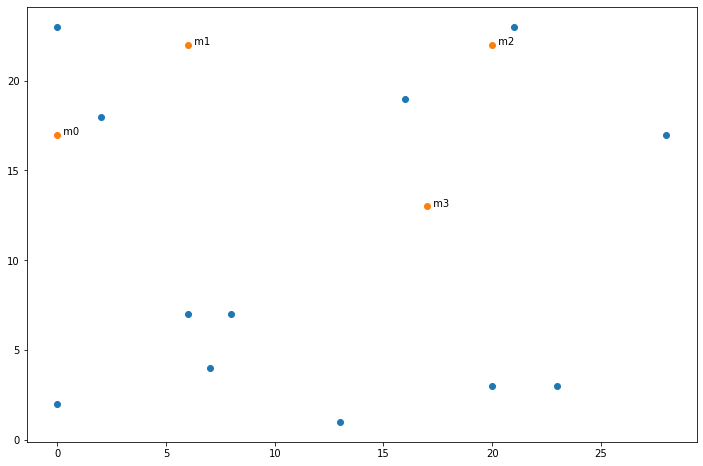

In [14]:
fig, ax = plt.subplots(figsize = (12,8))
# clients axe x et axe y
xclients, yclients = [client[0] for client in clients], [client[1] for client in clients]
# magasin axe x et axe y
xmagasins, ymagasins = [magasin[0] for magasin in magasins], [magasin[1] for magasin in magasins]
ax.scatter(xclients, yclients) 
ax.scatter(xmagasins, ymagasins)
for i in range(nmagasins):
    ax.annotate(f'  m{i}', (xmagasins[i],ymagasins[i]))
plt.show()

Initialisation du modèle

In [15]:
def ModelInit(arcs, capacité, demandes, distances, N, magasins):
    model = Model('CVRP')
    x = model.binary_var_dict(arcs, name = 'x') # variable binaire pour les arcs -> 0 ou 1 en fonction de si on le prend ou pas
    u = model.continuous_var_dict(N, ub = capacité, name = 'u') # ub = upperbound = capacité camionnette
    model.minimize(model.sum(distances[i,j]*x[i,j] for i,j in arcs)) # fct objectif = minimiser la distance entre les arcs qui sont sélectionnés
    # il faut entrer et sortir une et une seule fois de chaque sommet client
    model.add_constraints(model.sum(x[i,j] for j in V if j!=i) == 1 for i in N) 
    model.add_constraints(model.sum(x[i,j] for i in V if i!=j) == 1 for j in N)
    # contrainte qui s'active quand l'arc x[i, j] vaut 1 (sélectionné)
    model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i]+demandes[j] == u[j]) for i, j in arcs if ((i not in (magasins)) and (j not in (magasins))))
    model.add_constraints(u[i] >= demandes[i] for i in N)
    # model.parameters.timelimit = 60
    return model
  

In [16]:
def solver(model):
    return model.solve(clean_before_solve=True, log_output = False)

In [17]:
# fonction qui permet d'afficher le trajet du marchand entre ses dépôts et ses clients
def affichage(magasins):
    # identification des arcs actifs pour l'affichage
    arcs_actifs = []
    for val in (model.iter_binary_vars()):
        if val.solution_value > 0.95:
            v = val.name.split('_')
            arcs_actifs.append((int(v[1]), int(v[2])))
    fig, ax = plt.subplots(figsize = (18,12)) 
    # affichage des clients 
    noms = " - ".join(map(str,magasins))
    ax.scatter(xclients, yclients)

    for i in N:
        plt.annotate(f' w={demandes[i]}', (xtot[str(i)], ytot[str(i)]))

    # affichage des magasins 
    for i in magasins:
        plt.plot(xmagasins[i], ymagasins[i], c='r', marker='s') # affichage des magasins
    # annotation des magasins sur la carte
    for i in magasins:
        plt.annotate(f'  {i}', (xmagasins[i], ymagasins[i]))


    # affichage des arcs actifs
    for i,j in arcs_actifs:
        plt.plot([xtot[str(i)], xtot[str(j)]], [ytot[str(i)], ytot[str(j)]], c='g', alpha=0.4)
    
    # ajout des noms des magasins sur la carte
    plt.title(f"Magasins : {noms}")
    plt.show() 

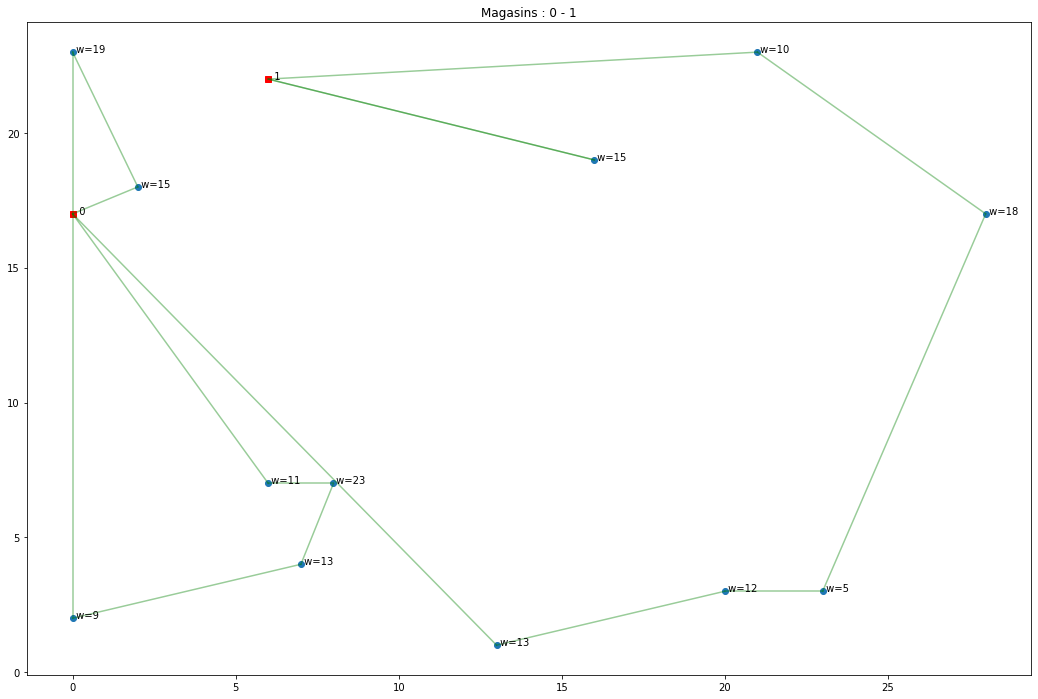

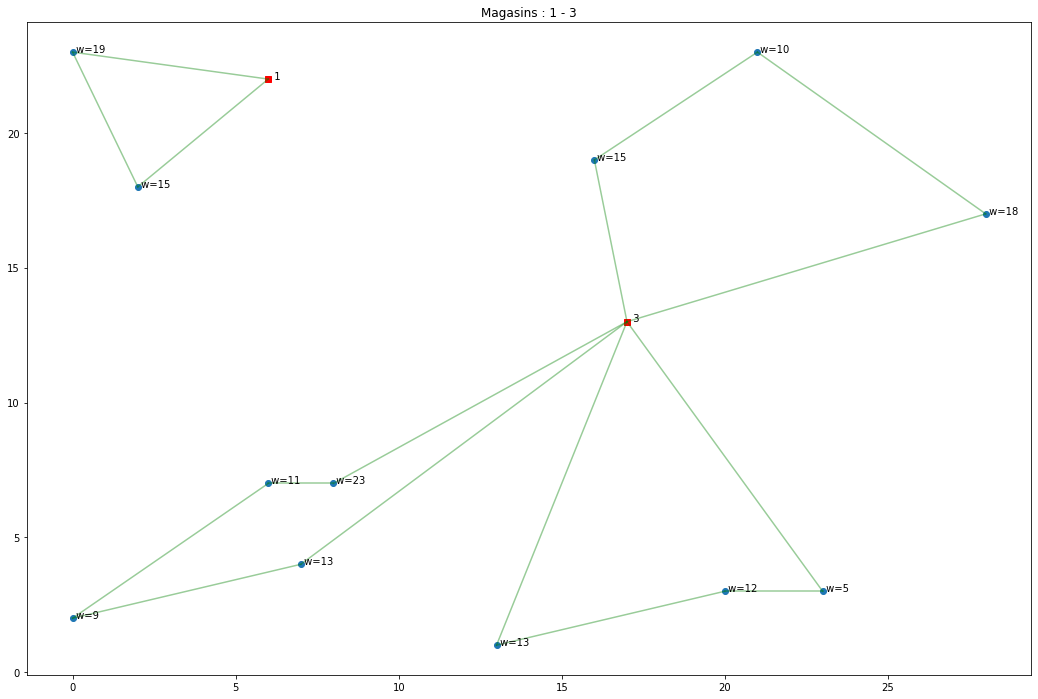

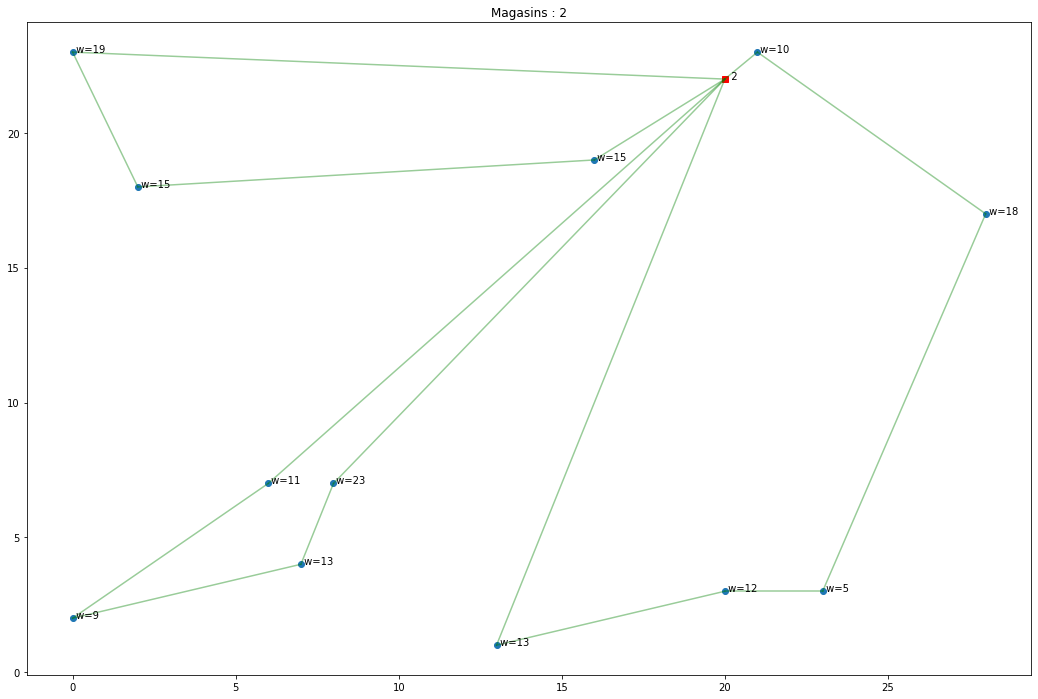

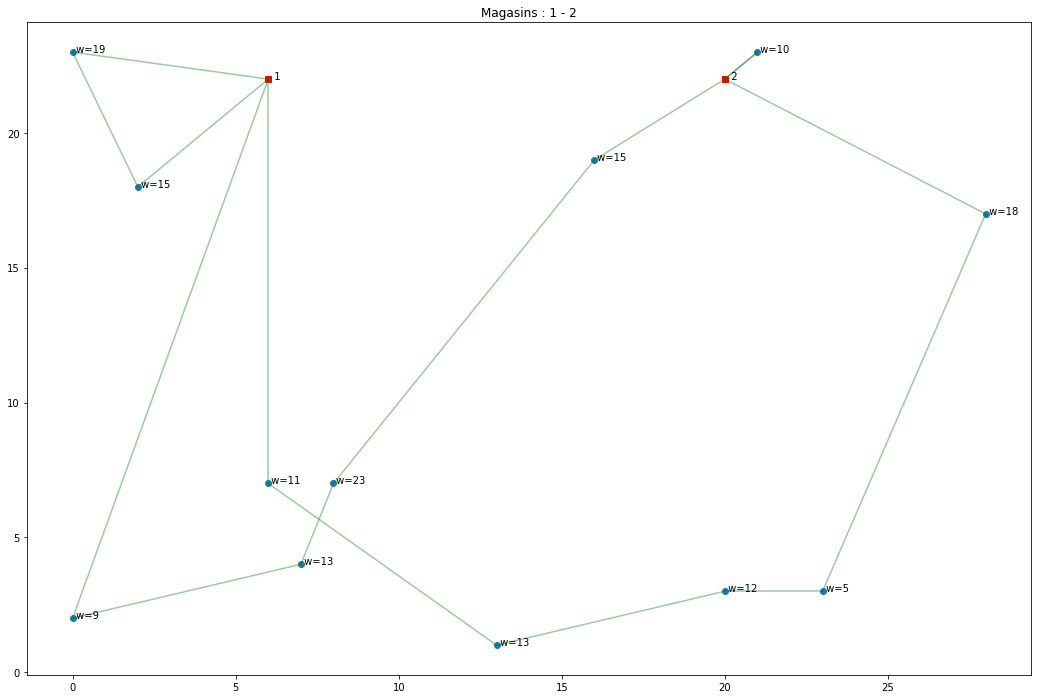

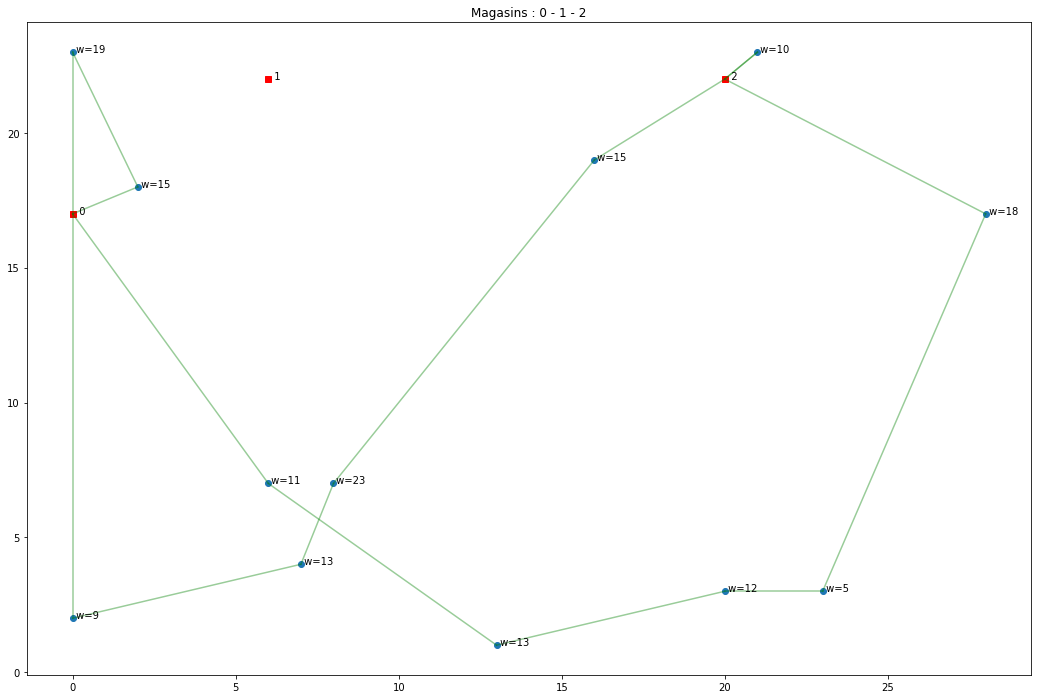

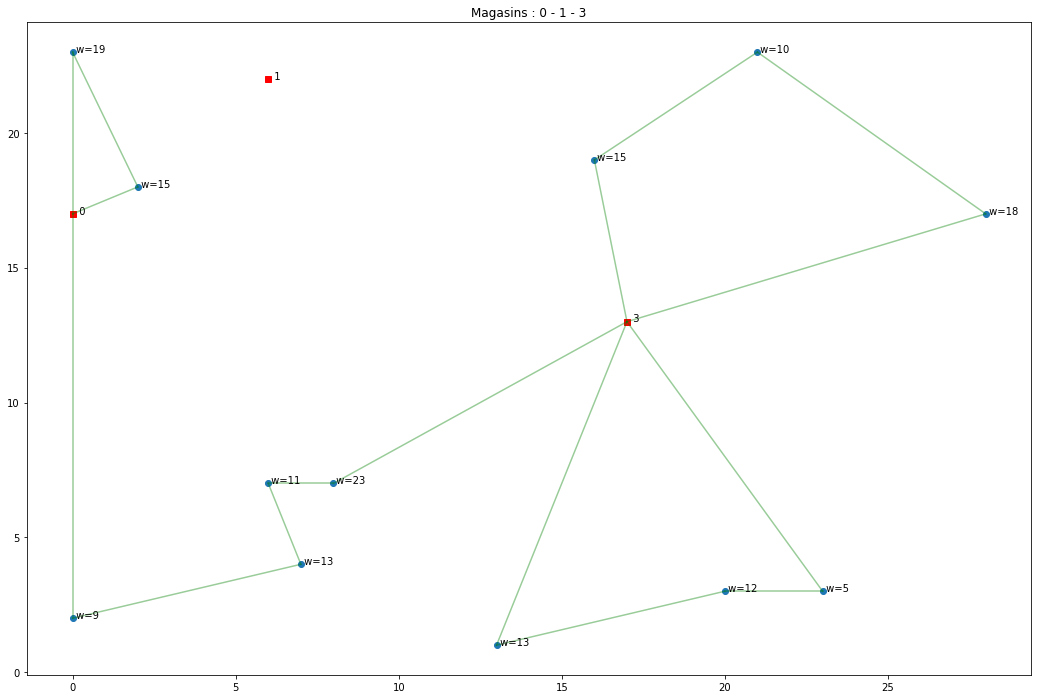

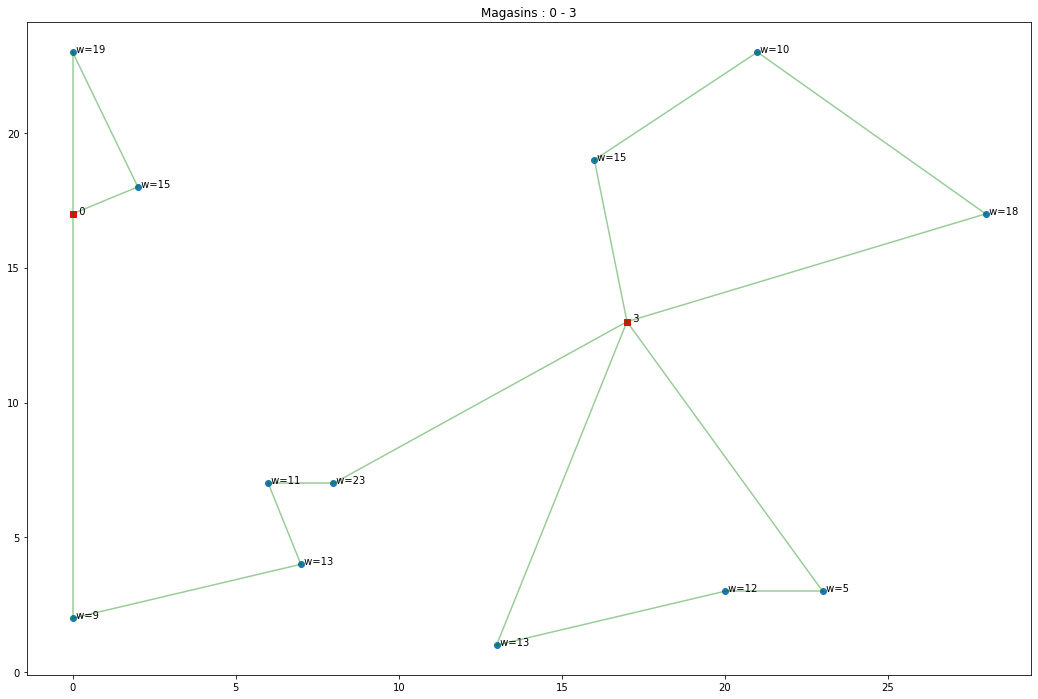

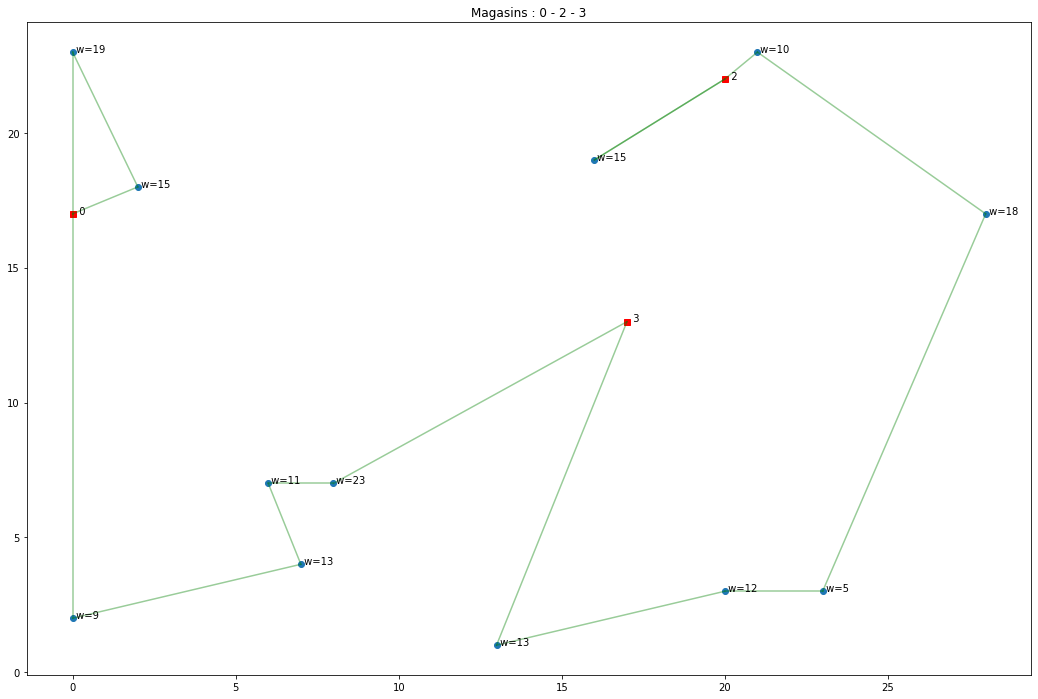

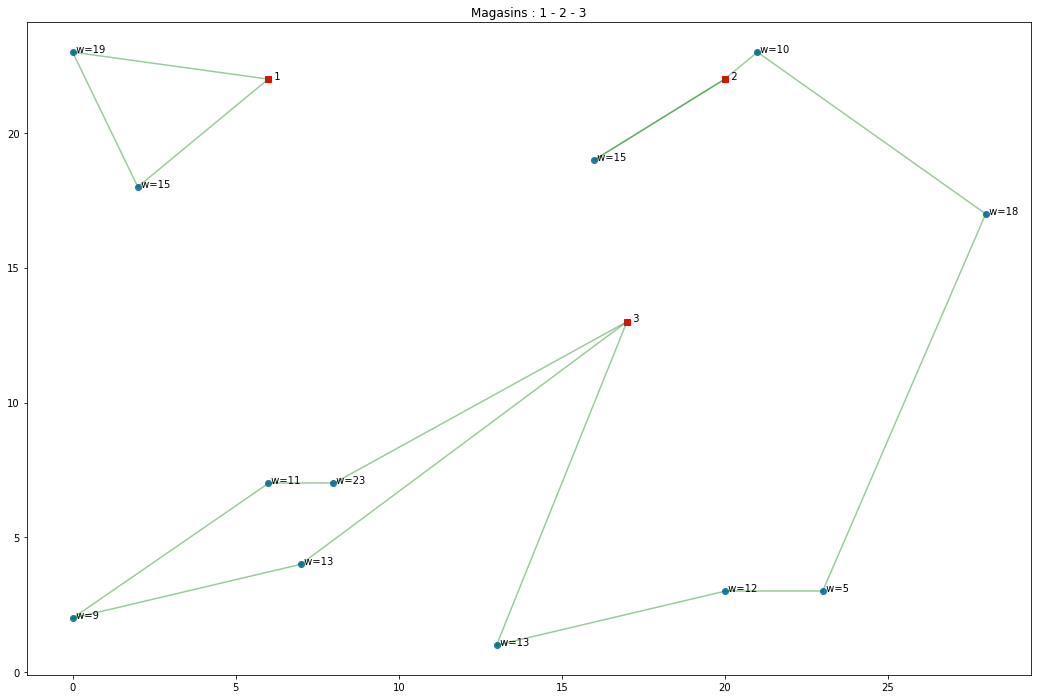

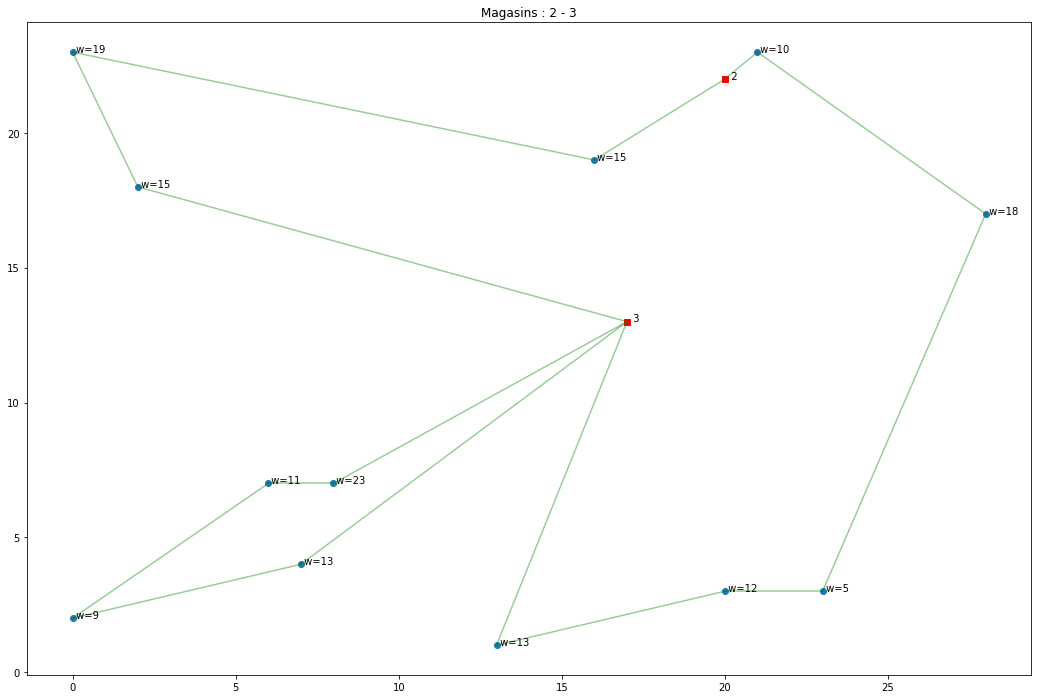

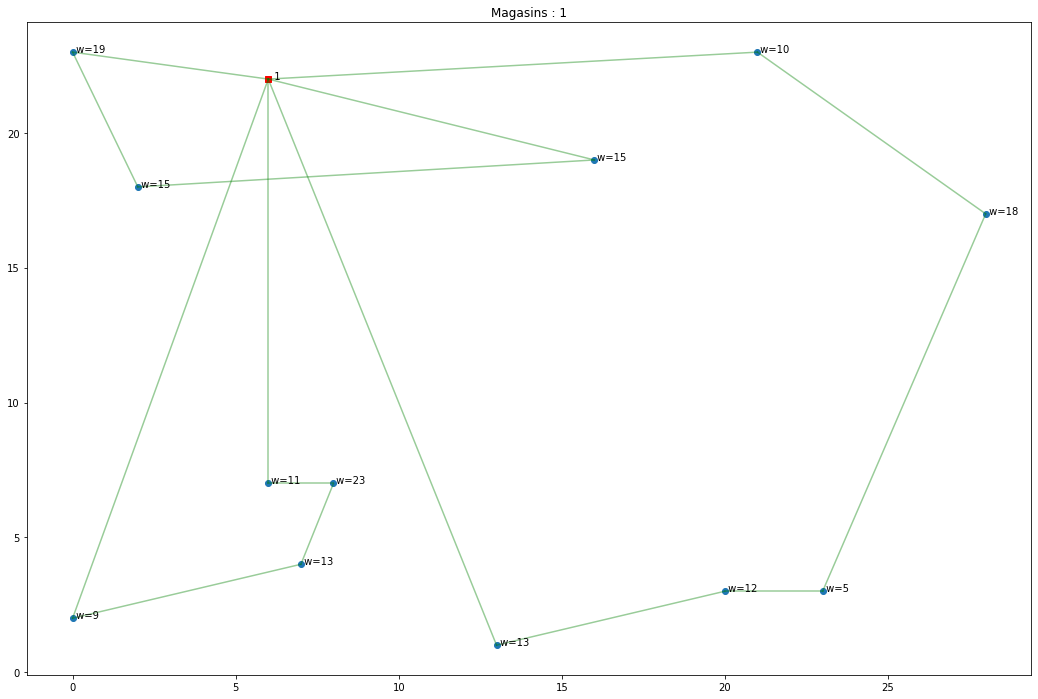

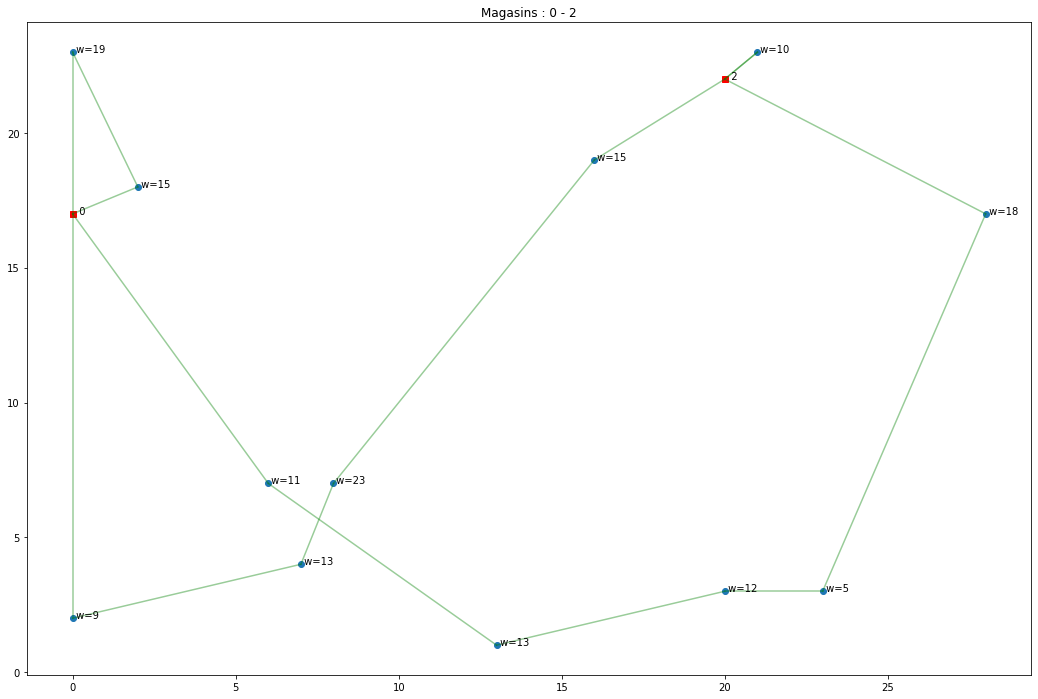

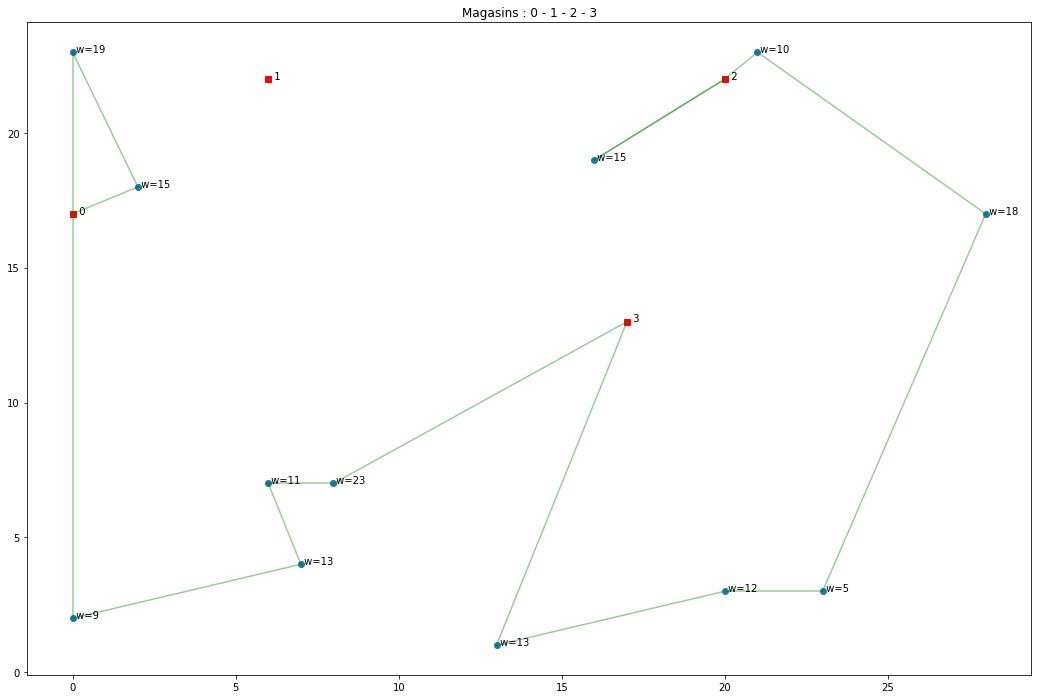

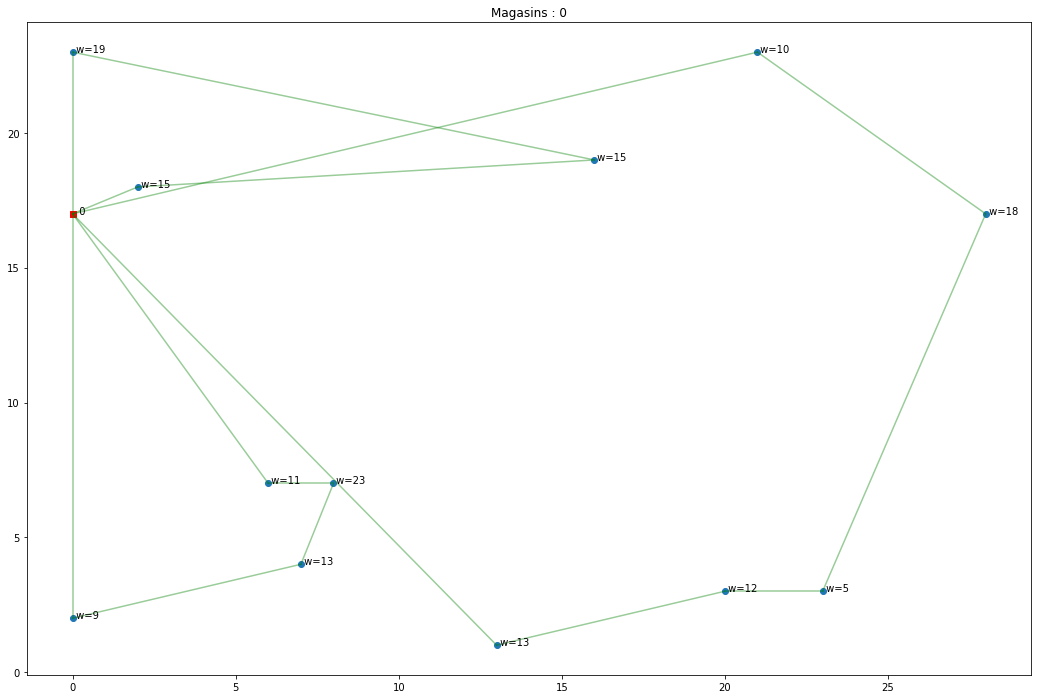

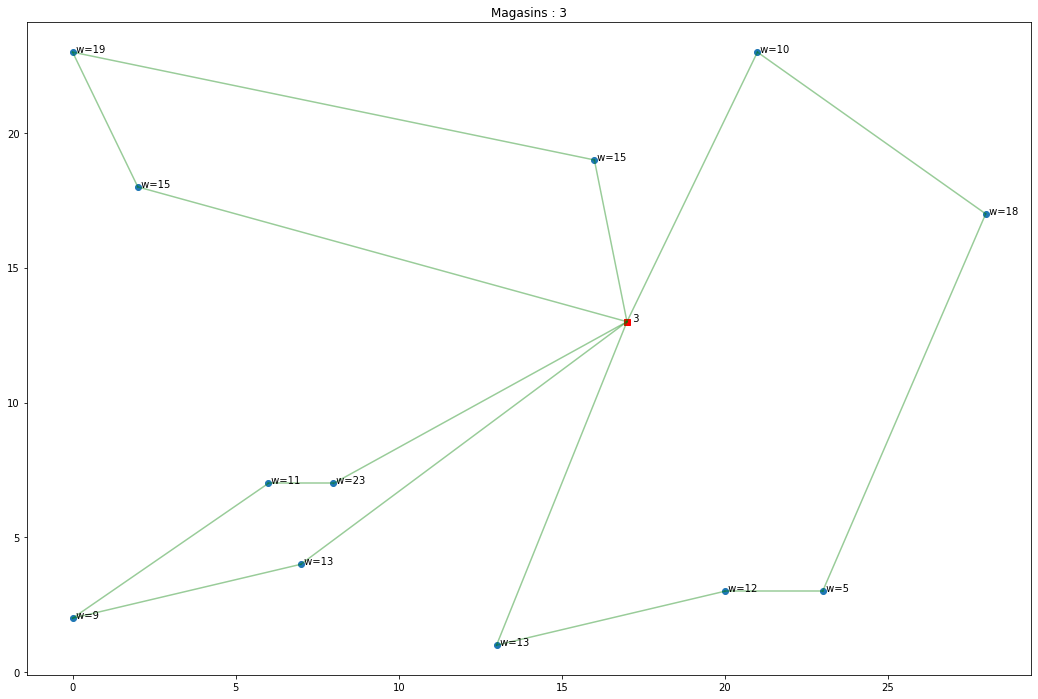

La plus petite distance à parcourir est 110.30932145741369
Le nombre d'emplacements idéal est 4 et c'est la combinaison :[0, 1, 2, 3]


In [18]:
import itertools
from time import perf_counter

# On veut chercher le meilleur chemin avec n magasins, il suffit de résoudre le problème indépendamment 
best_value = 10**10
best_magasin = None
best_solution = None

# Comme il suffit de calculer indépemment chaque sous problème et de garder le meilleur, on peut
# pré-calculer toutes les combinaisons possibles de magasins et tester avec chaque combinaison pour
# voir combien de dépôts il faut idéalement 
combi = set()
for k in range(1,nmagasins+1):
    for j in itertools.combinations(list(range(nmagasins)),k):
        combi.add(j)

# stocker les valeurs de chaque itération pour les afficher à la fin des runs -> magasins : distance
results = {}
# stocker le temps que prend chaque itération
times = {}

dem = [random.randint(lbdemande,ubdemande) for i in range(nclients)]
for c in (combi):
    # Magasins testés pour cette itération 
    magasins = list(c)
    # Clients
    N = [int(i) for i in range(c[-1]+1, nclients+c[-1]+1)]
    # Graphe qui reprend les clients + dépôts
    V = magasins + N
    # Demandes des clients
    demandes = {j:i for i,j in zip(dem,N)}
    # Axe x et y pour les magasins + les clients
    xtot, ytot = dict({str(x): xmagasins[x] for x in magasins},**{str(y):x for x,y in zip(xclients, N)}), dict({str(x): ymagasins[x] for x in magasins},**{str(y):x for x,y in zip(yclients, N)})
    # Arcs du graphe (on ne veut pas un arc entre 2 magasins directement ou entre un noeud et lui même)
    arcs = [(i,j) for i in V for j in V if ((i not in magasins or j not in magasins) and i != j)]
    # Calcul des distances entre les noeuds du graphe
    dists = {(i,j): np.hypot(xtot[str(i)]-xtot[str(j)],ytot[str(i)]-ytot[str(j)]) for i,j in arcs}
    # Initialisation du modèle
    model = ModelInit(arcs, capacité, demandes, dists, N, magasins)
    # On veut benchmark le temps de calcul
    start_time = perf_counter()
    # Lancement du solver
    solution = solver(model)
    end_time = perf_counter()
    value = solution.objective_value
    # on garde la meilleure solution
    if value < best_value:
        best_value = value 
        best_magasin = magasins
        best_solution = solution
    # si même distance mais avec moins de magasins -> alors on garde le parcours avec le moins de magasins
    elif value == best_value:
        if len(magasins) < len(best_magasin):
            best_value = value 
        best_magasin = magasins
        best_solution = solution
    # affichage sur une carte du parcours entre les magasins et les clients pour chaque cas testé
    affichage(magasins)
    # stockage des combinaisons de magasins avec leur distance pour l'affichage final 
    results[tuple(magasins)] = value
    times[(tuple(magasins))] = end_time-start_time 
    model.clear()
print(f'La plus petite distance à parcourir est {best_value}')
print(f"Le nombre d'emplacements idéal est {len(best_magasin)} et c'est la combinaison :{best_magasin}")

Affichage des distances en fonction du choix des dépôts

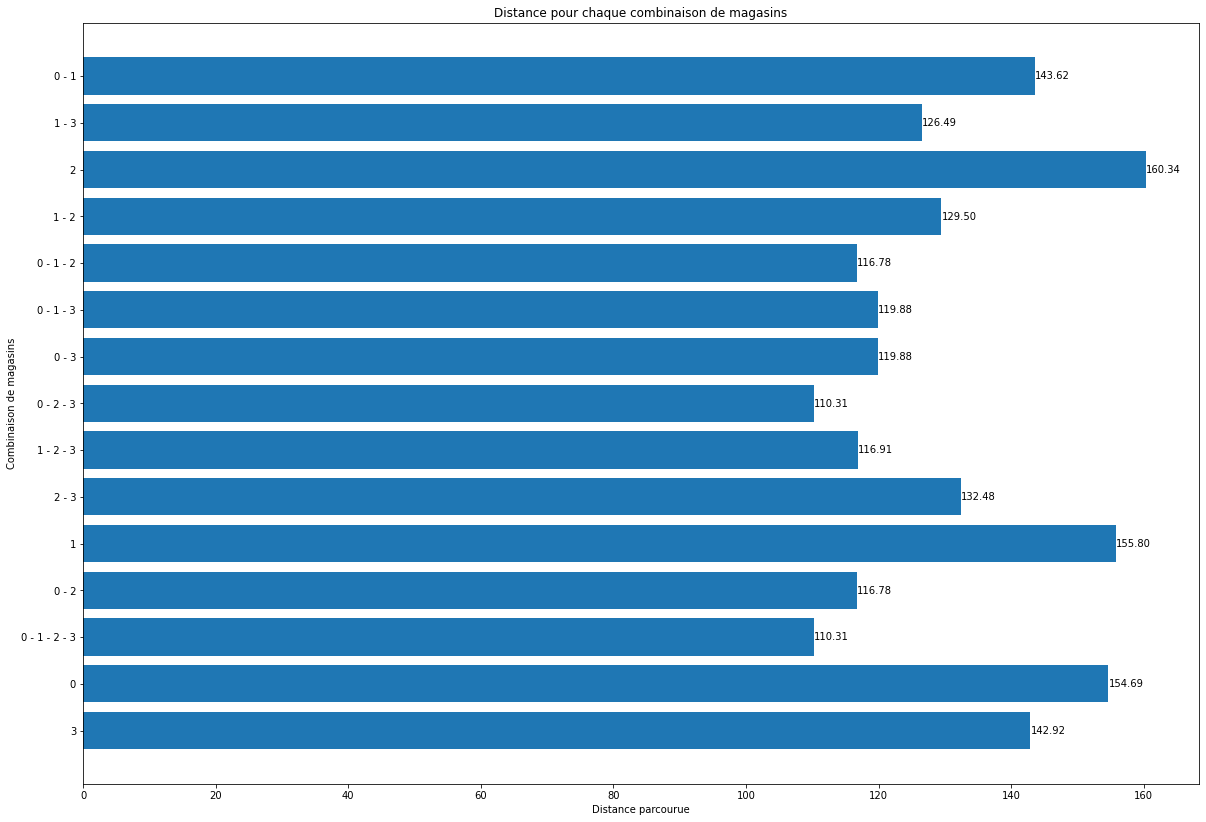

In [29]:
# on récupère les différentes combinaisons de magasins avec leur distance
names = tuple([" - ".join(map(str,list(m))) for m in results.keys()])
y_pos = np.arange(len(names))
distances = results.values()
fig, ax = plt.subplots(figsize = (20,14))

hbars = ax.barh(y_pos, distances, align='center')
ax.set_yticks(y_pos, labels=names)
ax.invert_yaxis()
ax.set_xlabel('Distance parcourue')
ax.set_title('Distance pour chaque combinaison de magasins')
ax.set_ylabel('Combinaison de magasins')
ax.bar_label(hbars, fmt='%.2f')

plt.show()


Affichage des temps pour chaque combinaison de magasins

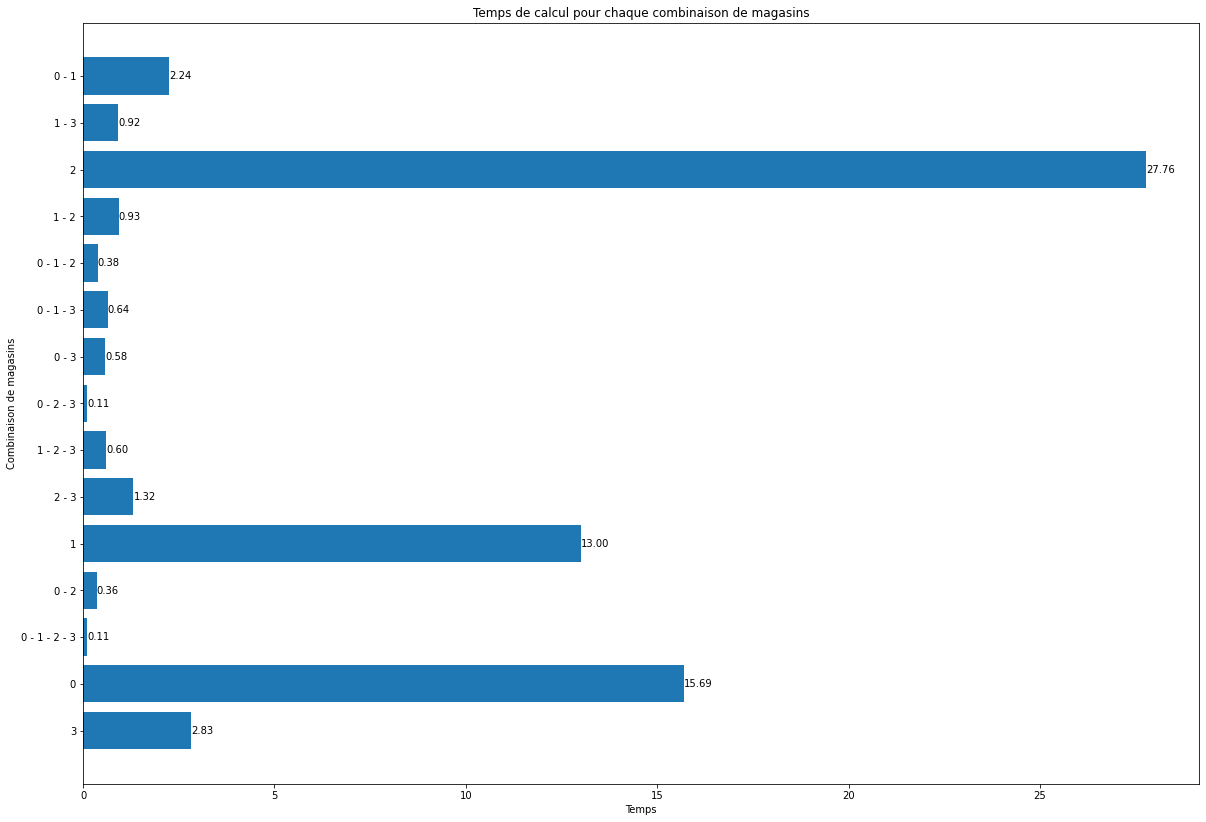

In [30]:
# on récupère les différentes combinaisons de magasins avec leur distance
names = tuple([" - ".join(map(str,list(m))) for m in results.keys()])
y_pos = np.arange(len(names))
temps = times.values()
fig, ax = plt.subplots(figsize = (20,14))

hbars = ax.barh(y_pos, temps, align='center')
ax.set_yticks(y_pos, labels=names)
ax.invert_yaxis()
ax.set_xlabel('Temps')
ax.set_title('Temps de calcul pour chaque combinaison de magasins (s)')
ax.set_ylabel('Combinaison de magasins')
ax.bar_label(hbars, fmt='%.2f')

plt.show()